# Security & Artificial Intelligence Project

## Authors :

* Alexandre Lemonnier
* Sarah Gutierez
* Victor Simonin

## Project objectives

The goal of the project is to design, deploy and evaluate a data chain for the analysis of
cybersecurity data. The data treatment will be performed as batch.

We chose Objective 1 :
   - Anomaly detection for tracking attacks
   
Our dataset :
   - The UGR’16 Dataset
   
Data date :
   - June - Week 1, Date range: 01/06/2016 - 05/06/2016

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sb
import numpy as np
import matplotlib.lines as mlines
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

## Import data
Here we import our train dataset from the first week of June.

In [2]:
col_names = ["Date", "Duration", "Source_IP", "Destination_IP", "Source_Port",
             "Destination_Port", "Protocol", "Flag", "Forwarding_Status", "Service_Type", "Packets", "Bytes", "Label"]

In [4]:
# data_june = pd.read_csv('data/train/june.week1.csv', names=col_names, nrows=10000000, skiprows=lambda i: i % 100 != 0)
data_june = pd.read_csv('data/train/june_week1_7M.csv', names=col_names)
data_june = data_june.sample(frac=1)

In [6]:
data_june.dtypes
#data_june.to_csv('data/train/june_week1_10M.csv')

Date                  object
Duration             float64
Source_IP             object
Destination_IP        object
Source_Port            int64
Destination_Port       int64
Protocol              object
Flag                  object
Forwarding_Status      int64
Service_Type           int64
Packets                int64
Bytes                  int64
Label                 object
dtype: object

In [7]:
genuine_repartition = 0.97
attack_repartition = 0.03

In [8]:
df_genuine = data_june[data_june['Label'] == 'background'].head(int(data_june.shape[0] * genuine_repartition))
df_attacks = data_june[data_june['Label'] != 'background'].head(int(data_june.shape[0] * attack_repartition))
train_df = pd.concat([df_genuine, df_attacks])

In [9]:
train_df["Date"]

6571600    2016-06-05 19:47:26
4014096    2016-06-03 21:42:10
6187941    2016-06-05 12:34:30
6650887    2016-06-05 21:11:57
5255566    2016-06-04 19:31:09
                  ...         
4994658    2016-06-04 15:08:12
3059273    2016-06-03 06:27:24
2083698    2016-06-02 12:56:16
1354746    2016-06-01 22:48:30
3221046    2016-06-03 09:36:33
Name: Date, Length: 6642475, dtype: object

The `test_df` is from the week 5 of july.

In [10]:
test_df = pd.read_csv('data/test/july.week5.csv', nrows=10000, names=col_names)
test_df.head()

,Date,Duration,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Flag,Forwarding_Status,Service_Type,Packets,Bytes,Label
0,2016-07-27 13:43:21,48.380,187.96.221.207,42.219.153.7,53,53,UDP,.A....,0,0,2,209,background
1,2016-07-27 13:43:21,48.380,42.219.153.7,187.96.221.207,53,53,UDP,.A....,0,0,2,167,background
2,2016-07-27 13:43:25,50.632,42.219.153.191,62.205.150.146,80,1838,TCP,.AP...,0,0,9,2082,background
3,2016-07-27 13:43:25,51.052,62.205.150.146,42.219.153.191,1838,80,TCP,.AP...,0,0,9,7118,background
4,2016-07-27 13:43:27,46.996,92.225.28.133,42.219.155.111,443,59867,TCP,.AP...,0,0,4,674,background


We stock the dataframes in the `data` list to apply the same cleaning:

In [11]:
data = { "train" : train_df, "test": test_df}

## General overview

In [12]:
data["train"].info()
print('_'*40)
data["test"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6642475 entries, 6571600 to 3221046
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Date               object 
 1   Duration           float64
 2   Source_IP          object 
 3   Destination_IP     object 
 4   Source_Port        int64  
 5   Destination_Port   int64  
 6   Protocol           object 
 7   Flag               object 
 8   Forwarding_Status  int64  
 9   Service_Type       int64  
 10  Packets            int64  
 11  Bytes              int64  
 12  Label              object 
dtypes: float64(1), int64(6), object(6)
memory usage: 709.5+ MB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               10000 non-null  object 
 1   Duration           10000 non-null  floa

**Which features are categorical?**

These values classify the samples into sets of similar samples. 

- **Categorical**: Date, Source_IP, Destination_IP, Source_Port, Destination_Port, Protocol, Flag, Label.

*Source_Port* and *Destination_Port* are of **int64** type, so we will have to categorize them. 

**Which features are numerical?**

These values change from sample to sample.

- **Numerical**: Duration, Forwarding Status, Type of Service, Packets, Bytes

In [13]:
for _, df in data.items():
    df['Source_Port'] = df['Source_Port'].astype(object)
    df['Destination_Port'] = df['Destination_Port'].astype(object)

In [14]:
cat_col = list(train_df.select_dtypes(include=object).columns.values)
cat_col

['Date',
 'Source_IP',
 'Destination_IP',
 'Source_Port',
 'Destination_Port',
 'Protocol',
 'Flag',
 'Label']

In [15]:
num_col = list(train_df._get_numeric_data().columns.values)
num_col

['Duration', 'Forwarding_Status', 'Service_Type', 'Packets', 'Bytes']

**Which features may contain errors or typos?**

We know that data come from a consistent netflow so they should be quite accurate.

**Which features contain blank, null or empty values?**

We can observe that dataframes do not contain any null value.

In [16]:
data["train"].isna().sum()

Date                 0
Duration             0
Source_IP            0
Destination_IP       0
Source_Port          0
Destination_Port     0
Protocol             0
Flag                 0
Forwarding_Status    0
Service_Type         0
Packets              0
Bytes                0
Label                0
dtype: int64

## Data analysis




Let's get statistics about the numerical data:

In [17]:
data["train"].describe()

,Duration,Forwarding_Status,Service_Type,Packets,Bytes
count,6.642475e+06,6642475.0,6.642475e+06,6.642475e+06,6.642475e+06
mean,4.565369e+00,0.0,7.686904e+00,2.157209e+01,1.598012e+04
std,2.379436e+01,0.0,2.094525e+01,2.577047e+03,3.588716e+06
min,0.000000e+00,0.0,0.000000e+00,1.000000e+00,2.800000e+01
25%,0.000000e+00,0.0,0.000000e+00,1.000000e+00,8.400000e+01
50%,1.880000e-01,0.0,0.000000e+00,3.000000e+00,1.800000e+02
75%,2.932000e+00,0.0,0.000000e+00,8.000000e+00,1.103000e+03
max,3.955960e+02,0.0,2.240000e+02,1.958717e+06,2.767223e+09


We observe that `Forwarding_Status` column is full of zeroes. We decide to drop it.

In [18]:
for _, df in data.items():
    df.drop(columns='Forwarding_Status', inplace=True)
data["train"].head()

,Date,Duration,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Flag,Service_Type,Packets,Bytes,Label
6571600,2016-06-05 19:47:26,0.000,36.130.53.164,42.219.159.181,0,0,ICMP,.A....,64,1,32,background
4014096,2016-06-03 21:42:10,0.000,42.219.159.86,150.32.235.97,0,769,ICMP,.A....,192,1,111,background
6187941,2016-06-05 12:34:30,0.076,210.31.109.70,42.219.156.211,49725,443,TCP,.A.R.F,0,3,120,background
6650887,2016-06-05 21:11:57,0.000,222.13.113.231,42.219.159.61,3544,57316,UDP,.A....,0,1,137,background
5255566,2016-06-04 19:31:09,0.000,52.51.186.53,42.219.155.59,80,54304,TCP,.A..S.,0,1,52,background


Let's get statistics about the categorical data:

In [19]:
train_df.describe(include=['O'])

,Date,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Flag,Label
count,6642475,6642475,6642475,6642475,6642475,6642475,6642475,6642475
unique,432061,377876,770247,65501,65467,8,25,4
top,2016-06-02 11:27:53,42.219.156.211,42.219.156.211,53,53,TCP,.A....,background
freq,242,529538,505838,937939,971170,4461340,2396776,6606670


Statistics analysis here ##TODO

## Preprocessing data

In [20]:
data["train"]['Label'].unique()

array(['background', 'blacklist', 'anomaly-sshscan', 'anomaly-spam'],
      dtype=object)

Let's numerize `Label` column with `0` value is the netflow is normal and `1` otherwise.

In [21]:
for _, df in data.items():
    df['Label'] = np.where(df['Label'] == 'background', 0, 1)
data["train"]['Label'].unique()

array([0, 1])

Let's divide `Date` column in multiple attributes, to analyse which one is relevant with the `Label` value.

In [22]:
for _, df in data.items():
    df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d %H:%M:%S", errors='ignore')
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['week'] = df['Date'].dt.isocalendar().week
    df['hour'] = df['Date'].dt.hour
    df['minute'] = df['Date'].dt.minute
    df['second'] = df['Date'].dt.second
    df['dayOfWeek'] = df['Date'].dt.dayofweek
    df.drop(columns='Date', inplace=True)

In [23]:
data["train"].head()

,Duration,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Flag,Service_Type,Packets,Bytes,Label,year,month,day,week,hour,minute,second,dayOfWeek
6571600,0.000,36.130.53.164,42.219.159.181,0,0,ICMP,.A....,64,1,32,0,2016,6,5,22,19,47,26,6
4014096,0.000,42.219.159.86,150.32.235.97,0,769,ICMP,.A....,192,1,111,0,2016,6,3,22,21,42,10,4
6187941,0.076,210.31.109.70,42.219.156.211,49725,443,TCP,.A.R.F,0,3,120,0,2016,6,5,22,12,34,30,6
6650887,0.000,222.13.113.231,42.219.159.61,3544,57316,UDP,.A....,0,1,137,0,2016,6,5,22,21,11,57,6
5255566,0.000,52.51.186.53,42.219.155.59,80,54304,TCP,.A..S.,0,1,52,0,2016,6,4,22,19,31,9,5


In [24]:
corr = data["train"].corr()
corr.style.background_gradient(cmap='coolwarm')

/usr/lib/python3.10/site-packages/pandas/io/formats/style.py:3554: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/lib/python3.10/site-packages/pandas/io/formats/style.py:3555: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Duration,Service_Type,Packets,Bytes,Label,year,month,day,week,hour,minute,second,dayOfWeek
Duration,1.000000,-0.013070,0.054511,0.033622,-0.008709,nan,nan,-0.022249,-0.001628,0.005190,-0.001066,0.000756,-0.021985
Service_Type,-0.013070,1.000000,-0.000851,-0.000788,0.011345,nan,nan,-0.043497,0.000441,-0.012405,-0.000974,0.000737,-0.043501
Packets,0.054511,-0.000851,1.000000,0.963212,-0.000248,nan,nan,-0.001023,0.000209,0.000203,-0.000054,0.000401,-0.001051
Bytes,0.033622,-0.000788,0.963212,1.000000,-0.000186,nan,nan,-0.000552,0.000129,-0.000045,-0.000042,0.000443,-0.000570
Label,-0.008709,0.011345,-0.000248,-0.000186,1.000000,nan,nan,-0.017360,-0.001502,-0.001533,0.001238,0.000939,-0.017120
year,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
month,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
day,-0.022249,-0.043497,-0.001023,-0.000552,-0.017360,nan,nan,1.000000,0.062368,-0.021307,-0.004780,-0.000251,0.989658
week,-0.001628,0.000441,0.000209,0.000129,-0.001502,nan,nan,0.062368,1.000000,-0.051093,-0.044892,-0.000936,-0.081443
hour,0.005190,-0.012405,0.000203,-0.000045,-0.001533,nan,nan,-0.021307,-0.051093,1.000000,0.000470,0.000717,-0.013934


We can observe that we have a lot of NaN corresponding to the different attribute of the date.  
Our data are based on the same `year`,`month` and `week` so we can drop these columns, they will not be relevant.  
In our batch of data, `day` is not relevant at all because we are only focusing on one week.

In [25]:
for _, df in data.items():
    df.drop(columns=['year', 'month', 'week', 'day'], inplace=True)

Moreover, we decide to replace `hour`, `minute`, `second` column with a delta from the beginning of the day.

In [26]:
for _, df in data.items():
    df['timeDelta'] = df['hour'] *3600 + df['minute'] * 60 + df['second']
    df.drop(columns=['hour', 'minute', 'second'], inplace=True)
data['train']

,Duration,Source_IP,Destination_IP,Source_Port,Destination_Port,Protocol,Flag,Service_Type,Packets,Bytes,Label,dayOfWeek,timeDelta
6571600,0.000,36.130.53.164,42.219.159.181,0,0,ICMP,.A....,64,1,32,0,6,71246
4014096,0.000,42.219.159.86,150.32.235.97,0,769,ICMP,.A....,192,1,111,0,4,78130
6187941,0.076,210.31.109.70,42.219.156.211,49725,443,TCP,.A.R.F,0,3,120,0,6,45270
6650887,0.000,222.13.113.231,42.219.159.61,3544,57316,UDP,.A....,0,1,137,0,6,76317
5255566,0.000,52.51.186.53,42.219.155.59,80,54304,TCP,.A..S.,0,1,52,0,5,70269
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994658,1.508,42.219.159.85,248.7.23.25,54736,443,TCP,....S.,0,3,152,1,5,54492
3059273,0.008,42.219.153.191,95.153.28.8,53,11360,UDP,.A....,0,7,455,1,4,23244
2083698,78.892,67.207.93.151,42.219.158.188,57490,80,TCP,.APRS.,0,54,9146,1,3,46576
1354746,0.000,42.219.158.188,143.72.8.137,42132,53,UDP,.A....,0,1,62,1,2,82110


In [27]:
data["train"][["Source_IP", "Label"]].groupby(["Source_IP"],as_index=False).mean().sort_values(by='Label', ascending=False).head()

,Source_IP,Label
238548,42.66.173.195,1.0
140255,213.184.114.154,1.0
271837,62.205.244.153,1.0
277061,64.143.46.29,1.0
294519,66.11.28.80,1.0


In [28]:
data["train"][["Destination_IP", "Label"]].groupby(['Destination_IP'],as_index=False).mean().sort_values(by='Label', ascending=False).head()

,Destination_IP,Label
591471,58.33.55.221,1.0
556506,50.131.121.188,1.0
295936,207.109.148.73,1.0
349374,213.93.160.209,1.0
584254,56.217.213.48,1.0


In [29]:
data["train"][["Source_Port", "Label"]].groupby(['Source_Port'],as_index=False).mean().sort_values(by='Label', ascending=False).head()

,Source_Port,Label
791,817,1.0
844,872,1.0
913,945,1.0
764,789,0.5
533,541,0.5


In [30]:
data["train"][["Destination_Port", "Label"]].groupby(['Destination_Port'],as_index=False).mean().sort_values(by='Label', ascending=False).head()

,Destination_Port,Label
870,923,1.0
854,904,1.0
591,603,1.0
804,847,1.0
534,538,1.0


In [31]:
data["train"][["Protocol", "Label"]].groupby(['Protocol'],as_index=False).mean().sort_values(by='Label', ascending=False)

,Protocol,Label
7,UDP,0.008604
6,TCP,0.003946
2,ICMP,0.001182
0,ESP,0.000000
1,GRE,0.000000
3,IPIP,0.000000
4,IPv6,0.000000
5,RSVP,0.000000


In [32]:
data["train"][["Flag", "Label"]].groupby(['Flag'],as_index=False).mean().sort_values(by='Label', ascending=False)

,Flag,Label
9,.A..S.,0.049750
8,.A...F,0.008638
7,.A....,0.007863
17,.AP.S.,0.005993
10,.A..SF,0.005843
4,...R..,0.004969
11,.A.R..,0.003824
12,.A.R.F,0.003621
21,.APRS.,0.003296
15,.AP...,0.003212


In [33]:
data["train"][["Service_Type", "Label"]].groupby(['Service_Type'],as_index=False).mean().sort_values(by='Label', ascending=False)

,Service_Type,Label
23,42,0.023981
21,40,0.011535
2,2,0.008590
39,104,0.007536
6,8,0.007134
34,75,0.007085
19,28,0.006745
4,4,0.006601
18,26,0.006064
31,72,0.005693


We can observe that for `Source_IP`, `Destination_IP`, `Source_Port` and `Destination_Port` column data is relevant for finding attacks because some IP and Port are only used for this type of netflow.

We will have to transform our categorical data in numerical data to use them in our classification model.  
We will use a **One Hot Encoder** transformer to numerize our categorical data.  

## Graphical analysis

In [63]:
def show3D_netflow_data(netflow_dataset, x_axis_name, y_axis_name, z_axis_name, only_error):
    X = netflow_dataset.drop(columns=['Label'])
    Y = netflow_dataset['Label']
    
    x = x_axis_name
    y = y_axis_name
    z = z_axis_name

    limit = len(X)

    sb.reset_orig()

    fig = plt.figure(figsize = (10, 12))
    
    ax = fig.add_subplot(111, projection='3d')
    if not only_error:
        ax.scatter((X.loc[Y == 0, x][:limit]),
                   np.log10(X.loc[Y == 0, y][:limit] + 0.1),
                   -np.log10(X.loc[Y == 0, z][:limit] + 0.1),
                   c = 'g',
                   marker = '.',
                   s = 1,
                   label = 'genuine')
    
    ax.scatter(np.log10(X.loc[Y == 1, x][:limit]),
               (X.loc[Y == 1, y][:limit] + 0.1),
               -np.log10(X.loc[Y == 1, z][:limit] + 0.1),
               c = 'r',
               marker = '.',
               s = 1,
               label = 'attack')
    
    ax.set_xlabel(x, size = 16)
    ax.set_ylabel(y + ' [hour]', size = 16)
    ax.set_zlabel('-log10(' + z + ')', size = 16)
    ax.set_title('Error-based features separate out genuine and attack netflow', size = 20)
    
    plt.axis('tight')
    ax.grid(1)
    
    noFraudMarker = mlines.Line2D([],
                                  [],
                                  linewidth = 0,
                                  color = 'g',
                                  marker = '.',
                                  markersize = 10,
                                  label = 'genuine')
    
    fraudMarker = mlines.Line2D([],
                                [],
                                linewidth = 0,
                                color = 'r',
                                marker = '.',
                                markersize = 10,
                                label = 'attack')
    
    plt.legend(handles = [noFraudMarker, fraudMarker],
               bbox_to_anchor = (1.20, 0.38),
               frameon = False,
               prop = {'size': 16})

/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


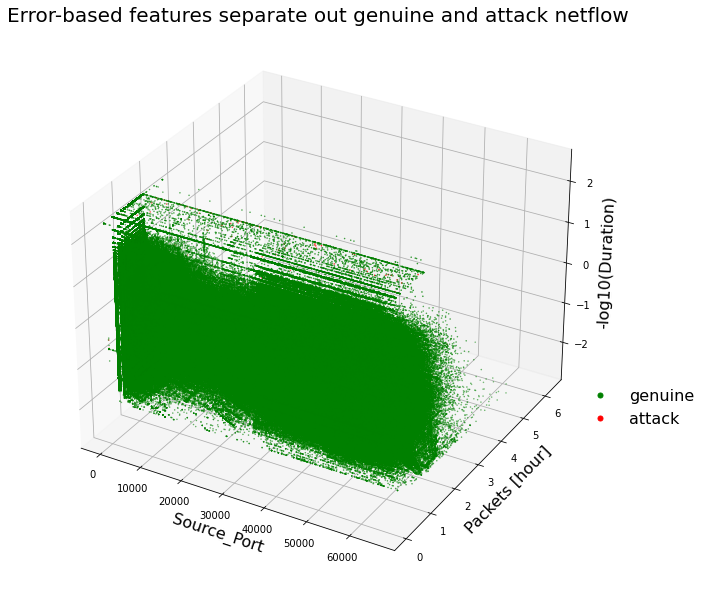

In [60]:
show3D_netflow_data(data["train"], 'Source_Port' , 'Packets', 'Duration', False)

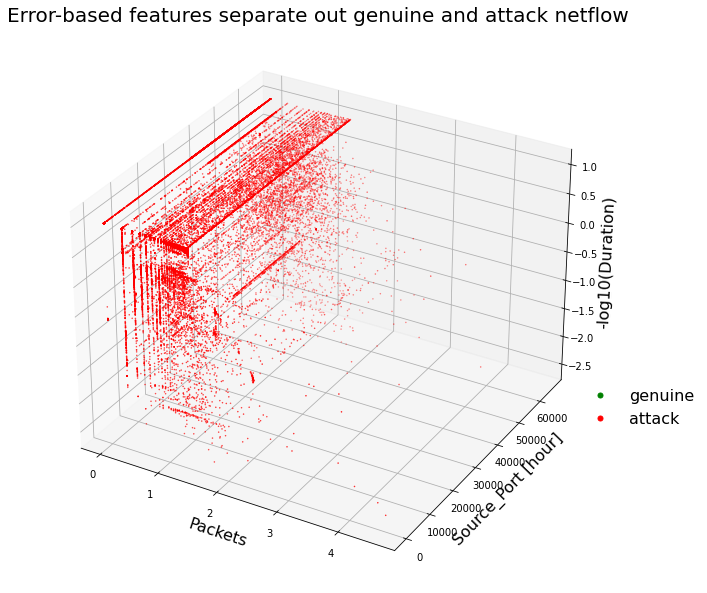

In [64]:
show3D_netflow_data(data["train"], 'Packets', 'Source_Port' , 'Duration', True)

/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


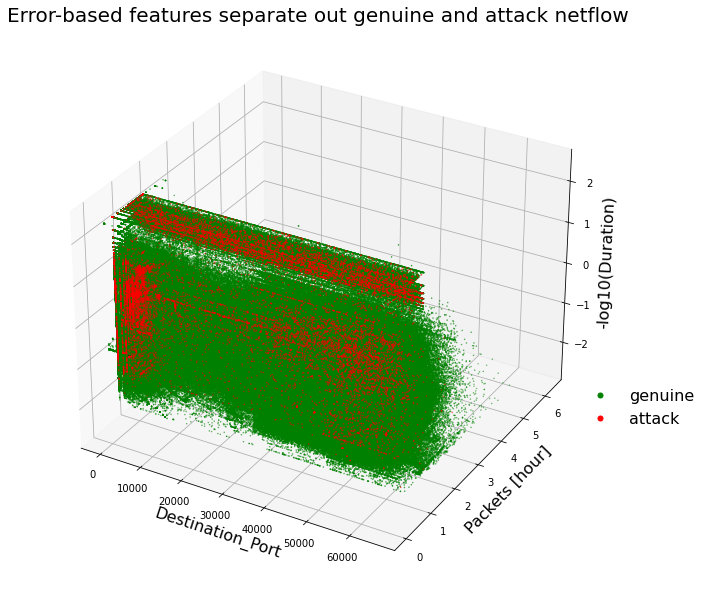

In [61]:
show3D_netflow_data(data["train"], 'Destination_Port' ,  'Packets', 'Duration', False)

/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


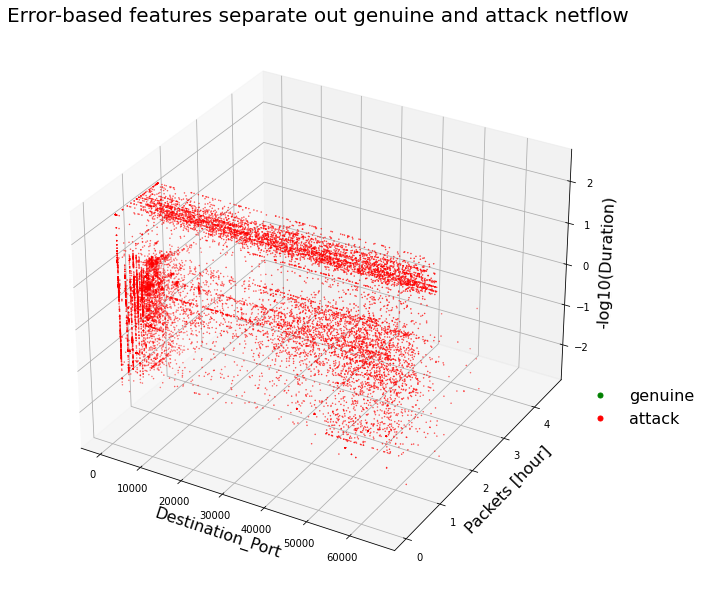

In [57]:
show3D_netflow_data(data["train"], 'Destination_Port' ,  'Packets', 'Duration', True)

We can observe that `Source_Port` and `Destination_Port` are relevant to find if a netflow is genuine or not. 

/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


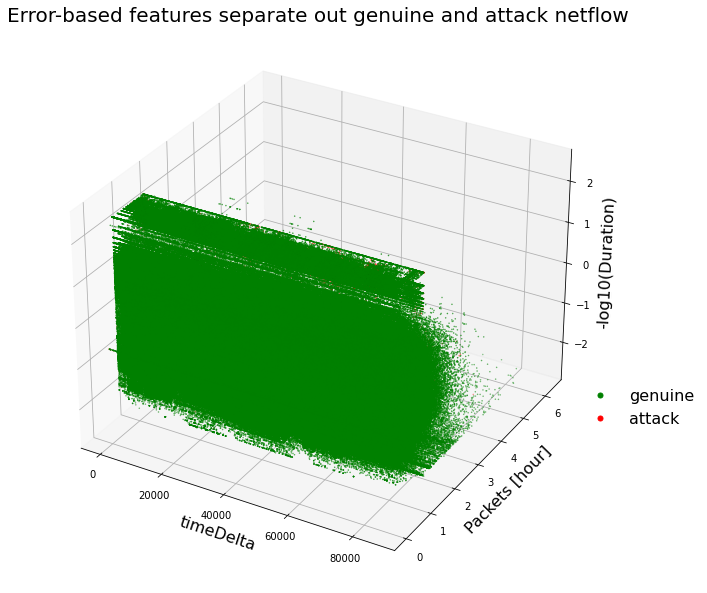

In [62]:
show3D_netflow_data(data["train"], 'timeDelta' , 'Packets', 'Duration', False)

/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


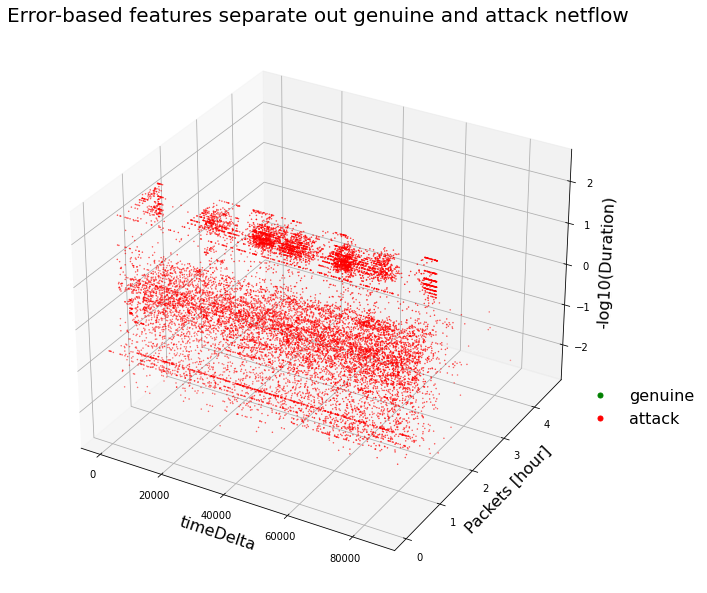

In [59]:
show3D_netflow_data(data["train"], 'timeDelta' , 'Packets', 'Duration', True)

## Supervised machine learning model benchmarking

In [65]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_recall_curve

In [66]:
cat_col = ['Source_IP', 'Destination_IP', 'Source_Port', 'Destination_Port', 'Protocol', 'Flag', 'Service_Type', 'dayOfWeek']
cat_col

['Source_IP',
 'Destination_IP',
 'Source_Port',
 'Destination_Port',
 'Protocol',
 'Flag',
 'Service_Type',
 'dayOfWeek']

In [67]:
num_col = ['Duration', 'Packets', 'Bytes', 'timeDelta']
num_col

['Duration', 'Packets', 'Bytes', 'timeDelta']

In [68]:
transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), cat_col))

In [69]:
X_train = data["train"].drop(columns=['Label'])
Y_train = data["train"]['Label'].copy()

In [70]:
X_test = data["test"].drop(columns=["Label"])
Y_test = data["test"]['Label'].copy()

In [71]:
classifier_score = {}

In [ ]:
def classifier_testing(classifier):
    print(f"Testing {classifier[0]}...")
    pipeline = Pipeline([
        ('transformer', transformer),
        ('classifier', classifier[1]),
    ])
    print("Fitting...")
    pipeline.fit(X_train, Y_train)
    print("Predicting...")
    y_pred = pipeline.predict(X_test)
    print("Scoring...")
    score = f1_score(Y_test, y_pred)
    print(f"{classifier[0]} score : {score}")
    classifier_score[classifier[0]] = score

In [ ]:
classifiers = {
    "SVC": SVC(),
    "LinearSVC": LinearSVC(),
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "Perceptron" : Perceptron(),
    "SGD" : SGDClassifier(),
    "DecisionTree" : DecisionTreeClassifier()
}

In [ ]:
#for key, value in classifiers.items():
#    classifier_testing((key, value))

In [ ]:
#for i, test in enumerate(classifier_score.items()):
#    plt.bar(i, test[1], label=test[0])
#plt.legend(bbox_to_anchor=(1, 0.25, 0.5, 0.5))

In [72]:
pipeline = Pipeline([
        ('transformer', transformer),
        ('classifier', DecisionTreeClassifier()),
    ])
print("Fitting...")
pipeline.fit(X_train, Y_train)
print("Predicting...")
y_pred = pipeline.predict(X_test)
print("Scoring...")
score = f1_score(Y_test, y_pred)
print(f"DecisionTree score : {score}")
y_score = pipeline.predict_proba(X_test)[:, 1]

Fitting...


In [ ]:
dT_results = X_test.copy()
dT_results["is_attack"] = y_pred == -1

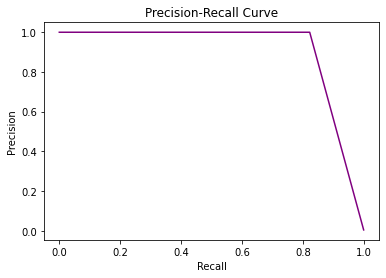

In [ ]:
precision, recall, thresholds = precision_recall_curve(Y_test, y_score)
#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

## Unsurpervised machine learning model
### Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest
pipeline = Pipeline(
    [
        ('transformer', transformer),
        ('classifier', IsolationForest(contamination=0.03, random_state=42))
    ]
)

In [ ]:
%time pipeline.fit(data["train"])

CPU times: user 7min 43s, sys: 13.1 s, total: 7min 56s
Wall time: 8min 4s


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Source_IP',
                                                   'Destination_IP',
                                                   'Source_Port',
                                                   'Destination_Port',
                                                   'Protocol', 'Flag',
                                                   'Service_Type',
                                                   'dayOfWeek'])])),
                ('classifier',
                 IsolationForest(contamination=0.03, random_state=42))])

In [ ]:
if_attack = pipeline.predict(data["train"])

In [ ]:
if_results = data["train"].copy()
if_results["if_attack"] = if_attack == -1

In [ ]:
nb_attacks = len(data["train"][data["train"].Label == 1])
nb_genuine = len(data["train"][data["train"].Label == 0])
print("True positive : ", len(if_results[(if_results["Label"] == 1) & (if_results["if_attack"] == True)]), "/", nb_attacks)
print("False positive :" , len(if_results[(if_results["Label"] == 0) & (if_results["if_attack"] == True)]), "/", nb_genuine)
print("True negative :" , len(if_results[(if_results["Label"] == 0) & (if_results["if_attack"] == False)]), "/", nb_genuine)
print("False negative :" , len(if_results[(if_results["Label"] == 1) & (if_results["if_attack"] == False)]), "/", nb_attacks)

True positive :  513 / 30000
False positive : 29475 / 970000
True negative : 29487 / 30000
False negative : 940525 / 970000


In [ ]:
if_results.groupby(by=['if_attack', 'Label']).count()

Duration  Source_IP  Destination_IP  Source_Port  \
if_attack Label                                                     
False     0        940525     940525          940525       940525   
          1         29487      29487           29487        29487   
True      0         29475      29475           29475        29475   
          1           513        513             513          513   

                 Destination_Port  Protocol    Flag  Service_Type  Packets  \
if_attack Label                                                              
False     0                940525    940525  940525        940525   940525   
          1                 29487     29487   29487         29487    29487   
True      0                 29475     29475   29475         29475    29475   
          1                   513       513     513           513      513   

                  Bytes  dayOfWeek  timeDelta  
if_attack Label                                
False     0      940525     940525     940525  
          1       29487      29487      29487  
True      0       29475      29475      29475  
          1         513        513        513

In [ ]:
def show3D_netflow_if_attack_only(transac_dataset, x_axis_name, y_axis_name, z_axis_name):
    X = transac_dataset.drop(columns=['if_attack'])
    Y = transac_dataset['if_attack']
    x = x_axis_name
    y = y_axis_name
    z = z_axis_name
    limit = len(X)
    sb.reset_orig()
    fig = plt.figure(figsize = (10, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(X.loc[Y == 1, x][:limit],
               X.loc[Y == 1, y][:limit],
               -np.log10(X.loc[Y == 1, z][:limit]),
               c = 'r',
               marker = '.', 
               s = 1, 
               label = 'if_attack')
    
    ax.set_xlabel(x, size = 16)
    ax.set_ylabel(y + ' [hour]', size = 16)
    ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
    ax.set_title('Features separate for attacks netflow', size = 20)
    
    plt.axis('tight')
    ax.grid(1)
    
    fraudMarker = mlines.Line2D([], [], linewidth = 0, color = 'r', marker = '.', markersize = 10, label = 'if_attack')
    
    plt.legend(handles= [fraudMarker], bbox_to_anchor = (1.20, 0.38), frameon = False, prop = {'size': 16})

/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


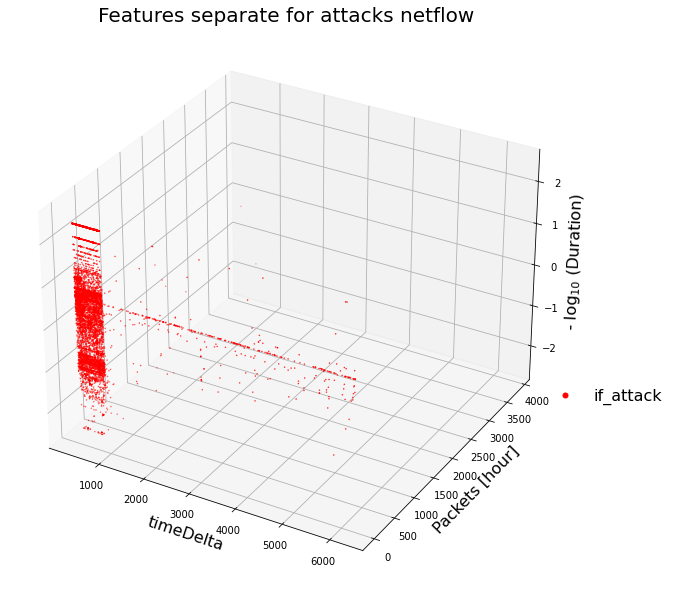

In [ ]:
show3D_netflow_if_attack_only(if_results, 'timeDelta', 'Packets', 'Duration')

### Local Outlier Factor

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
pipeline = Pipeline(
    [
        ('transformer', transformer),
        ('classifier', LocalOutlierFactor(contamination=0.03))
    ]
)
lof_attack = pipeline.fit_predict(data["train"])

In [ ]:
lof_results = data["train"].copy()
lof_results["lof_attack"] = lof_attack == -1

In [ ]:
nb_attacks = len(data["train"][data["train"].Label == 1])
nb_genuine = len(data["train"][data["train"].Label == 0])
print("True positive : ", len(lof_results[(lof_results["Label"] == 1) & (lof_results["lof_attack"] == True)]), "/", nb_attacks)
print("False positive :" , len(lof_results[(lof_results["Label"] == 0) & (lof_results["lof_attack"] == True)]), "/", nb_genuine)
print("True negative :" , len(lof_results[(lof_results["Label"] == 1) & (lof_results["lof_attack"] == False)]), "/", nb_attacks)
print("False negative :" , len(lof_results[(lof_results["Label"] == 0) & (lof_results["lof_attack"] == False)]), "/", nb_genuine)

True positive :  12 / 400
False positive : 290 / 9700
True negative : 388 / 400
False negative : 9410 / 9700


In [ ]:
lof_results.groupby(by=['lof_attack', 'Label']).count()

Duration  Source_IP  Destination_IP  Source_Port  \
lof_attack Label                                                     
False      0          9410       9410            9410         9410   
           1           388        388             388          388   
True       0           290        290             290          290   
           1            12         12              12           12   

                  Destination_Port  Protocol  Flag  Service_Type  Packets  \
lof_attack Label                                                            
False      0                  9410      9410  9410          9410     9410   
           1                   388       388   388           388      388   
True       0                   290       290   290           290      290   
           1                    12        12    12            12       12   

                  Bytes  dayOfWeek  timeDelta  
lof_attack Label                               
False      0       9410       9410       9410  
           1        388        388        388  
True       0        290        290        290  
           1         12         12         12

In [ ]:
def show3D_netflow_lof_attack_only(transac_dataset, x_axis_name, y_axis_name, z_axis_name):
    X = transac_dataset.drop(columns=['lof_attack'])
    Y = transac_dataset['lof_attack']
    x = x_axis_name
    y = y_axis_name
    z = z_axis_name
    limit = len(X)
    sb.reset_orig()
    fig = plt.figure(figsize = (10, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(X.loc[Y == 1, x][:limit],
               X.loc[Y == 1, y][:limit],
               -np.log10(X.loc[Y == 1, z][:limit]),
               c = 'r',
               marker = '.', 
               s = 1, 
               label = 'lof_attack')
    
    ax.set_xlabel(x, size = 16)
    ax.set_ylabel(y + ' [hour]', size = 16)
    ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
    ax.set_title('Features separate for attacks netflow', size = 20)
    
    plt.axis('tight')
    ax.grid(1)
    
    fraudMarker = mlines.Line2D([], [], linewidth = 0, color = 'r', marker = '.', markersize = 10, label = 'lof_attack')
    
    plt.legend(handles= [fraudMarker], bbox_to_anchor = (1.20, 0.38), frameon = False, prop = {'size': 16})

/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


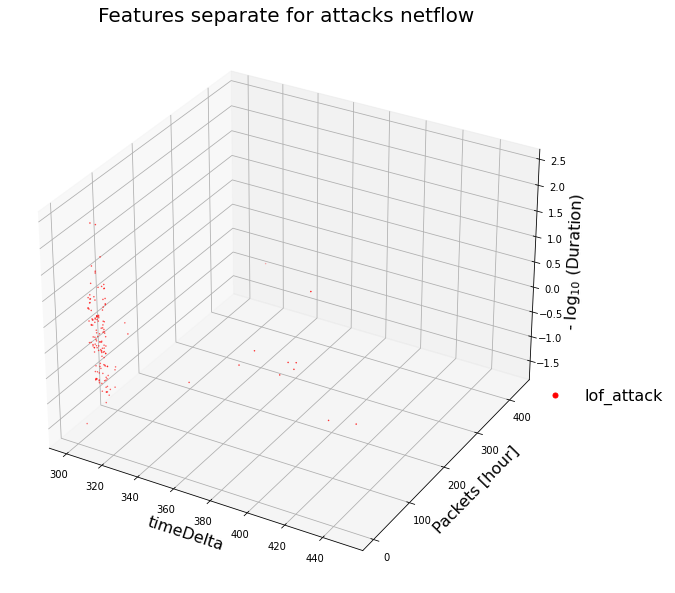

In [ ]:
show3D_netflow_lof_attack_only(lof_results, 'timeDelta', 'Packets', 'Duration')